# Replication Notebook of Jeppe Druedahl (2021): A Guide on Solving Non-convex Consumption-Saving Models

### Author: Adrian Monninger

## The DurableConsumerType
The `DurableConsumerType` inherits many attributes from the `IndShockConsumerType`. The only difference is that a durable good can be consumed as well. Hence, each household has the utility function:
\begin{align}
    u(c_t, d_t) &= \frac{(c_t^\alpha (d_t + \underline{d})^{1 - \alpha})^{1 - \rho}}{1 - \rho}
\end{align}
Where $c_t$, and $d_t$ is the non-durable and durable consumpation, $\rho$ is the coefficient of relative risk aversion, and $\alpha$ is the Cobb-Douglas parameter.

The household can adjust the stock of durable goods $n_t$ which means that $d_t \neq n_t$. To do so, a proportional adjustment cost $\tau \in (0,1)$ occurs.

Therefore, the household's end of period assets $a_t = m_t - c_t - d_t$. The consumer cannot borrow $a_t \geq 0$ and he interest rateis $r$. Hence, next-period cash-on-hand is
\begin{align}
    m_{t+1} &= Ra_t + y_{t+1}
\end{align}

The durable stock depreciates each period with rate $\delta \in (0,1)$:
\begin{align}
    n_{t+1} = (1 - \delta)n_t
\end{align}

The Bellman Equation is given by the maximum over the value functions of keeping $d_t = n_t$, and adjusting $d_t \neq n_t$. Or:
\begin{align}
    v_t(n_t,m_t) &= \max_{c_t, d_t, a_t} \Big(v_t^{keep}(n_t,m_t), v_t^{adj}(n_t, m_t) \Big)\\
    & \text{s.t.}\\
    a_t &= m_t- c_t - d_t(1 + \delta) \geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}

Where we have the Bellman for the keeper:
\begin{align}
    v_t^{keep}(n_t,m_t) &= \max_{c_t} u(c_t,n_t) + \beta \mathbb{E}_t \Big(v_{t+1}(n_{t+1}, m_{t+1})\Big)\\
    & \text{s.t.}\\
    a_t &= m_t- c_t \geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}

And for the adjuster
\begin{align}
    v_t^{adj}(n_t,m_t) &= \max_{c_t,n_t} u(c_t,n_t) + \beta \mathbb{E}_t \Big(v_{t+1}(n_{t+1}, m_{t+1})\Big)\\
    & \text{s.t.}\\
    a_t &= m_t- c_t - d_t(1 + \delta) \geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}

### Implementation (nested endogeneous grid-method)
The nested endogeneous grid method takes advantage of the fact, that the post-decision value function is the same for adjuster and keeper:
\begin{align}
    w_t(d_t, a_t) = \beta E[v_{t+1} (n_{t+1}, m_{t+1})].
\end{align}
Hence, the keeper problem gets:
\begin{align}
    v_t^{keep}(n_t,m_t) &= \max_{c_t} u(c_t,n_t) + w_t(d_t, a_t)\\
    & \text{s.t.}\\
    a_t &= m_t- c_t \geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}

Additionally, when we think of the problem as sequential, meaning first, $d_t$ is determined, and then how much to consume and save, we can write:
\begin{align}
    v_t^{adj}(n_t,m_t) &= \max_{d_t} v_t^{keep}(n_t,m_t)\\
    & \text{s.t.}\\
    a_t &= m_t- c_t - d_t(1 + \delta) \geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}

For the EGM part, we need the Euler equation:
\begin{align}
    u_c(c_t,n_t) &= \alpha c_t^{\alpha(1 - \rho) - 1} n_t^{(1 - \alpha)(1 - \rho)} = q_t
\end{align}
The idea is that we fix the end-of-perid asset state $a_t$ and then use the Euler-equation and the budget constraint to infer respectively the consumption choice $c_t$ and the level of cash-on-hand $m_t$.

Additionally, as we have a discrete choice, we need to apply an upper-envelope algorithm.This is necessary, as we have a discrete choice of adjusting or not-adjusting. Hence, we have a kink in the value function, meaning that for different values of $c_t$ and $d_t$, we get the same utility. Hence, the value function is not concave anymore! To deal with that, we use this algorithm which essentially gets rid of the parts of the value function which are decreasing.

### Implementation Steps:
1. Compute the post-decision functions $w_t$ and $q_t$ on a grid over the post-decision states $d_t, a_t$
2. Solve the keeper problem on a grid over the pre-decision states $n_t, m_t$ where the combined EGM and upper envelope is applied for each $n_t$
3. Solve the adjuster problem using interpolation of the keeper value function found in step 2.

### Original Source
Jeppe Druedahl published a notebook:
https://github.com/NumEconCopenhagen/ConsumptionSavingNotebooks 

#### Useful HARK notebooks:
1. Discrete choice (retirement decision)
https://github.com/econ-ark/EndogenousRetirement/blob/master/Endogenous-Retirement.ipynb
2. Upper Envelope Theorem
https://github.com/econ-ark/DemARK/blob/master/notebooks/DCEGM-Upper-Envelope.ipynb
3. How the IndShockConsumerType works 
https://github.com/econ-ark/HARK/blob/master/examples/HowWeSolveIndShockConsumerType/HowWeSolveIndShockConsumerType.ipynb


# Code Example

In [1]:
### Import
import numpy as np
from copy import deepcopy
from DurableModel import DurableConsumerType
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType, ConsumerSolution, init_idiosyncratic_shocks
import time # to time

from HARK.utilities import plot_funcs_der, plot_funcs
import matplotlib.pyplot as plt

### The Baseline Case
We start as simple as possible with `alpha = 1`, `dDepr = 1`, and, `adjC = 1`. Hence, the solution is the same as in `IndShockConsumerType`.

In [2]:
init_durable = dict(
    init_idiosyncratic_shocks,
    **{
        "alpha": 1.0, # Cobb-Douglas parameter for non-durable good consumption in utility function
        "dDepr": 1, # Depreciation Rate of Durable Stock
        "adjC": 1.0, # Adjustment costs
        "d_ubar": 1e-2,  # Minimum durable stock for utility function
        # For Grids
        "nNrmMin": 0.0,
        "nNrmMax": 5,
        "nNrmCount": 100,
        "mNrmMin": 0.0,
        "mNrmMax": 10,
        "mNrmCount": 100,
        "xNrmMin": 0.0,
        "xNrmMax": 10,  # xMax = mNrmMax + (1 - adjC)* nNrmMax
        "xNrmCount": 100,
        "aNrmMin": 0.0,
        "aNrmMax": 11,  #xNrmMax+1.0
        "aNrmCount": 100,
        ### No income shocks
        "PermGroFac": [1.00],
        "PermShkCount": 7,
        "PermShkStd": [0.0],
        "TranShkStd": [0.0],
        "UnempPrb": 0.0,
        "UnempPrbRet": 0.0,
        "LivPrb": [1.0],
        ### For simulation
        "T_sim": 2,
        "AgentCount": 10,
        ### Others
        "BoroCnstArt": 0,
        "BoroCnstdNrm": 0, # Borrowing Constraint of durable goods.
    }
)

In [3]:
# ### Parameter:
# init_durable = dict(
#     init_idiosyncratic_shocks,
#     **{
#         #"alpha": 0.9, # Cobb-Douglas parameter for non-durable good consumption in utility function
#         "alpha": 1.0,
#         #"dDepr": 0.1, # Depreciation Rate of Durable Stock
#         "dDepr": 1,
#         #"adjC": 0.15, # Adjustment costs
#         "adjC": 1.0,
#         "d_ubar": 1e-2,  # Minimum durable stock for utility function
#         "nNrmMin": 0.0,  # For Grids
#         #"dNrmMax": 20,
#         #"dNrmMax": 5,
#         "nNrmMax": 2.5,
#         "nNrmCount": 100,
#         #"dNrmCount": 50,
#         "xNrmMin": 0.0,
#         #"xNrmMax": 100 + 20,  # mMax = 100 + dNrmMax
#         #"xNrmMax": 25,  # xNrmMax = mNrmMax + (1 - adjC)nNrmMax
#         "xNrmMax": 12.5,
#         "xNrmCount": 100,
#         #"xNrmCount": 50,
#         "aNrmMin": 0.0,
#         #"aNrmMax": 100 + 20 + 1,  #xNrmMax+1.0
#         #"aNrmMax": 36,  #xNrmMax+1.0
#         "aNrmMax": 18,
#         "aNrmCount": 100,
#         #"aNrmCount": 50,
#         "mNrmMin": 0.0,
#         #"mNrmMax": 100,
#         #"mNrmMax": 25,
#         "mNrmMax": 12.5,
#         "mNrmCount": 100,
#         #"mNrmCount": 50,
#         ### No income shocks
#         "PermGroFac": [1.00],
#         "PermShkCount": 7,
#         "PermShkStd": [0.0],
#         "TranShkStd": [0.0],
#         "UnempPrb": 0.0,
#         "UnempPrbRet": 0.0,
#         "LivPrb": [1.0],
#         ### For simulation
#         "aNrmInitMean": 0.0,
#         "aNrmInitStd": 1.0,
#         "T_sim": 2,
#         "AgentCount": 10,
#         ### Others
#         "BoroCnstArt": 0,
#         "BoroCnstdNrm": 0, # Cannot have negative durable Stock
#         "tol": 1e-08, # tolerance for optimization function and when to adjust vs keep
#     }
# )

In [4]:
#### For Comparison, define parameters for the IndShockConsumerType
init_indshock = dict(
    init_idiosyncratic_shocks,
    **{
        ### No income shocks
        "PermGroFac": [1.0],
        "PermShkCount": 7,
        "PermShkStd": [0.0],
        "TranShkStd": [0.0],
        "UnempPrb": 0.0,
        "UnempPrbRet": 0.0,
        "LivPrb": [1.0],
        ### For simulation
        "aNrmInitMean": 0.0,
        "aNrmInitStd": 0.0,
        "T_sim": 2,
        "AgentCount": 10,
        ### Others
        "BoroCnstArt": 0,
    }
)

### Solve IndShockConsumerType
IndShockExample = IndShockConsumerType(**init_indshock)
IndShockExample.update_income_process()
IndShockExample.solve()#(verbose=False)

grid = np.linspace(0,10,100)
cFunc_IndShock = np.zeros(len(grid))
for i in range(len(grid)):
    cFunc_IndShock[i] = IndShockExample.solution[0].cFunc(grid[i])


In [5]:
### Define A function which calculates consumption, vlaue and adjusting function
def Graphfunctions(AgentType, grid, n):
    grid_x = (1 - AgentType.adjC)*n + grid
    # Consumption Functions
    cFunc_test = np.zeros(len(grid))
    dFunc_test = np.zeros(len(grid))
    exFunc_test = np.zeros(len(grid))
    cFuncKeep_test = np.zeros(len(grid))
    dFuncKeep_test = np.zeros(len(grid))
    exFuncKeep_test = np.zeros(len(grid))
    cFuncAdj_test = np.zeros(len(grid))
    dFuncAdj_test = np.zeros(len(grid))
    exFuncAdj_test = np.zeros(len(grid))
    
    # Value Functions
    vFunc_test = np.zeros(len(grid))
    vFuncKeep_test = np.zeros(len(grid))
    vFuncAdj_test = np.zeros(len(grid))
   
    # Adjuster Function
    adjusting = np.zeros(len(grid))

    for i in range(len(grid)):
        cFunc_test[i] = AgentType.solution[0].cFunc(n,grid[i])
        dFunc_test[i] = AgentType.solution[0].dFunc(n,grid[i])
        exFunc_test[i] = AgentType.solution[0].exFunc(n,grid[i])
        cFuncKeep_test[i] = AgentType.solution[0].cFuncKeep(n,grid[i])
        dFuncKeep_test[i] = AgentType.solution[0].dFuncKeep(n,grid[i])
        exFuncKeep_test[i] = AgentType.solution[0].exFuncKeep(n,grid[i])
        cFuncAdj_test[i] = AgentType.solution[0].cFuncAdj(grid_x[i])
        dFuncAdj_test[i] = AgentType.solution[0].dFuncAdj(grid_x[i])
        exFuncAdj_test[i] = AgentType.solution[0].exFuncAdj(grid_x[i])
        # Value Functions
        vFunc_test[i] = AgentType.solution[0].vFunc(n,grid[i])
        vFuncKeep_test[i] = AgentType.solution[0].vFuncKeep(n,grid[i])
        vFuncAdj_test[i] = AgentType.solution[0].vFuncAdj(grid_x[i])
        adjusting[i] = AgentType.solution[0].adjusting(n,grid[i])
    
    return {"cFunc_test": cFunc_test,
            "dFunc_test": dFunc_test, 
            "exFunc_test": exFunc_test,
            "cFuncKeep_test": cFuncKeep_test,
            "dFuncKeep_test": dFuncKeep_test, 
            "exFuncKeep_test": exFuncKeep_test, 
            "cFuncAdj_test": cFuncAdj_test,
            "dFuncAdj_test": dFuncAdj_test, 
            "exFuncAdj_test": exFuncAdj_test, 
            "vFunc_test": vFunc_test,
            "vFuncKeep_test":vFuncKeep_test,
            "vFuncAdj_test":vFuncAdj_test,
            "adjusting":adjusting,}

In [6]:
### Solve and time
start = time.time()
DurableExample = DurableConsumerType(**init_durable)
DurableExample.update_income_process()
DurableExample.solve()#(verbose=False)

end = time.time()
time_used_1 = end - start
print("time used: ", time_used_1, " seconds")

time used:  6.191840410232544  seconds


In [7]:
### What is saved:
print(vars(DurableExample.solution[0]))

{'cFunc': <HARK.interpolation.BilinearInterp object at 0x000001E43BA51220>, 'cFuncAdj': <HARK.interpolation.LinearInterp object at 0x000001E43BA510A0>, 'cFuncKeep': <HARK.interpolation.BilinearInterp object at 0x000001E46828C7F0>, 'dFunc': <HARK.interpolation.BilinearInterp object at 0x000001E43BA51250>, 'dFuncAdj': <HARK.interpolation.LinearInterp object at 0x000001E43BA51100>, 'dFuncKeep': <HARK.interpolation.BilinearInterp object at 0x000001E46828C4C0>, 'exFunc': <HARK.interpolation.BilinearInterp object at 0x000001E43BA51280>, 'exFuncAdj': <HARK.interpolation.LinearInterp object at 0x000001E43BA51160>, 'exFuncKeep': <HARK.interpolation.BilinearInterp object at 0x000001E46828C4F0>, 'vFunc': <HARK.interpolation.BilinearInterp object at 0x000001E43BA512B0>, 'vFuncAdj': <HARK.interpolation.LinearInterp object at 0x000001E43BA511C0>, 'vFuncKeep': <HARK.interpolation.BilinearInterp object at 0x000001E43BA51040>, 'vPfunc': <HARK.utilities.NullFunc object at 0x000001E43BA51340>, 'uPFunc': 

What is new:
1. Separate functions for the keeper's and adjuster's problem: FuncKeep, FuncAdj
2. dFunc: For durable consumption
3. exFunc: Total expenditure function
4. adjusting: 

Consumption function for an idiosyncratic shocks consumer type with durable stock = 0


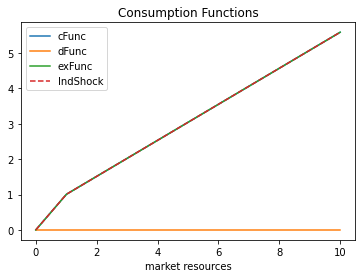

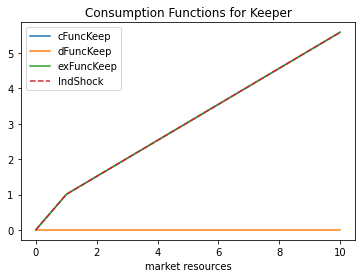

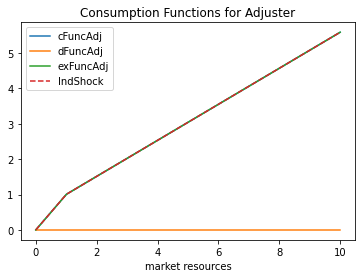

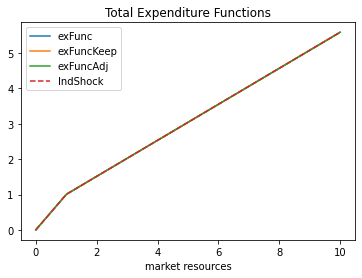

In [8]:
### Let's plot with initial durable stock of 0
n = 0
grid = np.linspace(0,10,100)
print('Consumption function for an idiosyncratic shocks consumer type with durable stock =', n)
Results = Graphfunctions(DurableExample,grid,n)

plt.plot(grid, Results['cFunc_test'], label = "cFunc")
plt.plot(grid, Results['dFunc_test'], label = "dFunc")
plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFuncKeep_test'], label = "cFuncKeep")
plt.plot(grid, Results['dFuncKeep_test'], label = "dFuncKeep")
plt.plot(grid, Results['exFuncKeep_test'], label = "exFuncKeep")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions for Keeper')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFuncAdj_test'], label = "cFuncAdj")
plt.plot(grid, Results['dFuncAdj_test'], label = "dFuncAdj")
plt.plot(grid, Results['exFuncAdj_test'], label = "exFuncAdj")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions for Adjuster')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid, Results['exFuncKeep_test'], label = "exFuncKeep")
plt.plot(grid, Results['exFuncAdj_test'], label = "exFuncAdj")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Total Expenditure Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

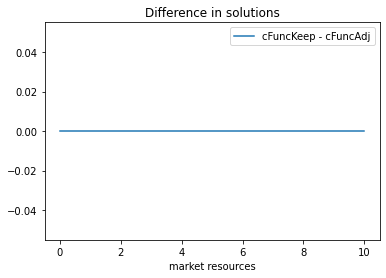

In [9]:
plt.plot(grid, Results['cFuncKeep_test'] - Results['cFuncAdj_test'] , label = "cFuncKeep - cFuncAdj")
plt.title('Difference in solutions')
plt.xlabel('market resources')
plt.legend()
plt.show()

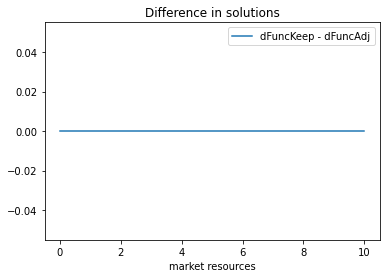

In [10]:
plt.plot(grid, Results['dFuncKeep_test'] - Results['dFuncAdj_test'] , label = "dFuncKeep - dFuncAdj")
plt.title('Difference in solutions')
plt.xlabel('market resources')
plt.legend()
plt.show()

Value function for an idiosyncratic shocks consumer type with durable stock = 0


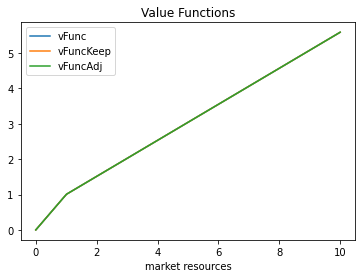

In [11]:
print('Value function for an idiosyncratic shocks consumer type with durable stock =', n)

plt.plot(grid, Results['vFunc_test'], label = "vFunc")
plt.plot(grid, Results['vFuncKeep_test'], label = "vFuncKeep")
plt.plot(grid, Results['vFuncAdj_test'], label = "vFuncAdj")
plt.title('Value Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()


Adjusting Function for an idiosyncratic shocks consumer type with durable stock = 0


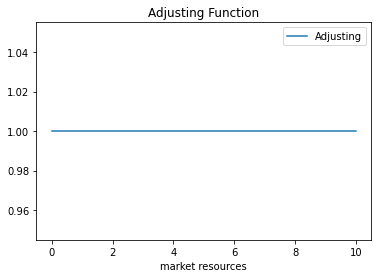

In [12]:
print('Adjusting Function for an idiosyncratic shocks consumer type with durable stock =', n)

plt.plot(grid, Results['adjusting'], label = "Adjusting")
plt.title('Adjusting Function')
plt.xlabel('market resources')
plt.legend()
plt.show()

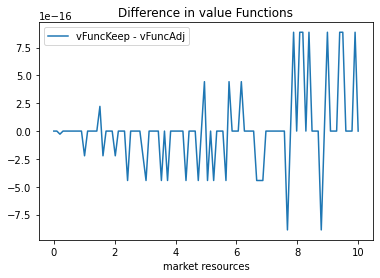

In [13]:
plt.plot(grid, Results['vFuncKeep_test'] - Results['vFuncAdj_test'] , label = "vFuncKeep - vFuncAdj")
plt.title('Difference in value Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

### Interpretation:
As alpha = 1, we should have exactly the same as for the IndShockConsumer ($c \in (0,3)$ with a kink at m=1) which we do! Additionally, solutions for keeper and adjuster is exactly the same.

Bug:
- Value functions are slightly different! Before interpolation: exactly the same. Problem with Linear and Bilinear inteprolation?
- if not a bug: Put tolerance between adjusting and keeping eg adjust if vKeep - tol >  vAdj and tol = 1e-8

### What happens if we increase 'n'?

Consumption function for an idiosyncratic shocks consumer type with durable stock = 2


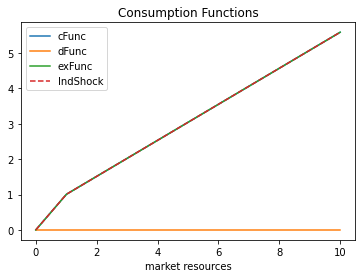

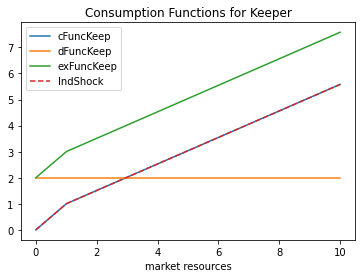

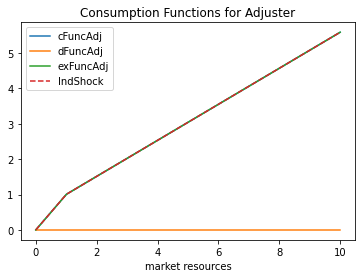

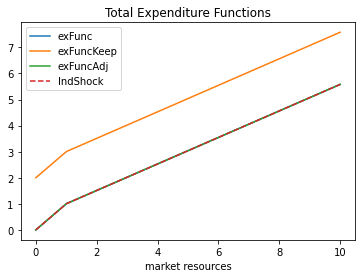

In [14]:
n = 2
print('Consumption function for an idiosyncratic shocks consumer type with durable stock =', n)
Results = Graphfunctions(DurableExample,grid,n)

plt.plot(grid, Results['cFunc_test'], label = "cFunc")
plt.plot(grid, Results['dFunc_test'], label = "dFunc")
plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFuncKeep_test'], label = "cFuncKeep")
plt.plot(grid, Results['dFuncKeep_test'], label = "dFuncKeep")
plt.plot(grid, Results['exFuncKeep_test'], label = "exFuncKeep")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions for Keeper')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFuncAdj_test'], label = "cFuncAdj")
plt.plot(grid, Results['dFuncAdj_test'], label = "dFuncAdj")
plt.plot(grid, Results['exFuncAdj_test'], label = "exFuncAdj")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions for Adjuster')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid, Results['exFuncKeep_test'], label = "exFuncKeep")
plt.plot(grid, Results['exFuncAdj_test'], label = "exFuncAdj")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Total Expenditure Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

Value function for an idiosyncratic shocks consumer type with durable stock = 2


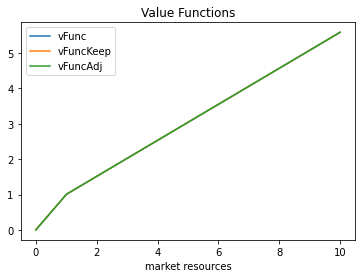

In [15]:
print('Value function for an idiosyncratic shocks consumer type with durable stock =', n)

plt.plot(grid, Results['vFunc_test'], label = "vFunc")
plt.plot(grid, Results['vFuncKeep_test'], label = "vFuncKeep")
plt.plot(grid, Results['vFuncAdj_test'], label = "vFuncAdj")
plt.title('Value Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

Adjusting Function for an idiosyncratic shocks consumer type with durable stock = 2


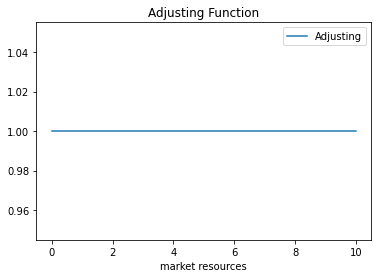

In [16]:
print('Adjusting Function for an idiosyncratic shocks consumer type with durable stock =', n)

plt.plot(grid, Results['adjusting'], label = "Adjusting")
plt.title('Adjusting Function')
plt.xlabel('market resources')
plt.legend()
plt.show()

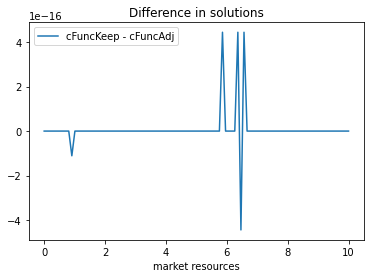

In [17]:
plt.plot(grid, Results['cFuncKeep_test'] - Results['cFuncAdj_test'] , label = "cFuncKeep - cFuncAdj")
plt.title('Difference in solutions')
plt.xlabel('market resources')
plt.legend()
plt.show()

### Interpretation:
As we still have alpha = 1 and adjustment costs = 1, there is no point in holding, consuming, or selling durables. Hence, the solution for the adjuster does not change. The keeper cFunc does not change either, only the exFunc_Keeper is shifted upwards by n.

### Case 1: No adjustment costs
With no adjustment costs (`adjC = 0`) and an initial durable stock, the adjuster sells the stock completely to consume more non-durable goods or increase savings. For the keeper, the total expenditure curve is shifted upwards, while the non-durable consumption function remains the same as above and as for the IndShockConsumerType.

If n is small enough, the agent is still constraint andthe kink remains. If n is large enough, the consumption function becomes a straight line parallel to the unconstraint consumption function.

In [18]:
DurableExampleadjC = deepcopy(DurableExample)
DurableExampleadjC.adjC = 0.0
DurableExampleadjC.dDepr = 1
DurableExampleadjC.update_income_process()
DurableExampleadjC.solve()#(verbose=False)

Consumption function for an idiosyncratic shocks consumer type with durable stock = 0.25 , alpha 1.0 , and Adjustment Costs 0.0


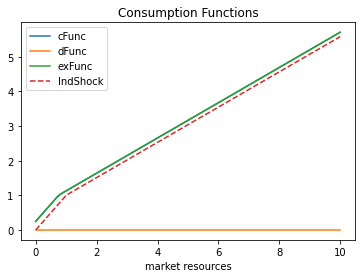

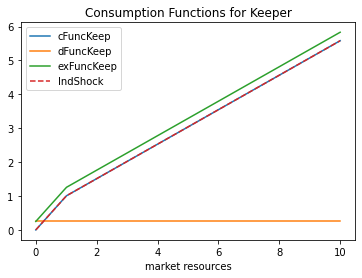

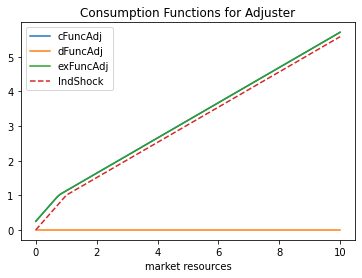

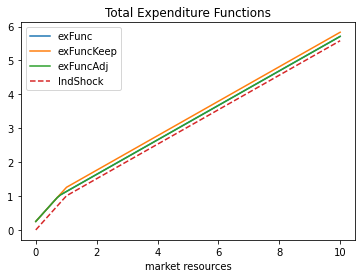

In [19]:
n = 0.25
print('Consumption function for an idiosyncratic shocks consumer type with durable stock =', 
      n, ', alpha', DurableExampleadjC.alpha, ', and Adjustment Costs', DurableExampleadjC.adjC)

Results = Graphfunctions(DurableExampleadjC,grid,n)

plt.plot(grid, Results['cFunc_test'], label = "cFunc")
plt.plot(grid, Results['dFunc_test'], label = "dFunc")
plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFuncKeep_test'], label = "cFuncKeep")
plt.plot(grid, Results['dFuncKeep_test'], label = "dFuncKeep")
plt.plot(grid, Results['exFuncKeep_test'], label = "exFuncKeep")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions for Keeper')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFuncAdj_test'], label = "cFuncAdj")
plt.plot(grid, Results['dFuncAdj_test'], label = "dFuncAdj")
plt.plot(grid, Results['exFuncAdj_test'], label = "exFuncAdj")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions for Adjuster')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid, Results['exFuncKeep_test'], label = "exFuncKeep")
plt.plot(grid, Results['exFuncAdj_test'], label = "exFuncAdj")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Total Expenditure Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()


Value function for an idiosyncratic shocks consumer type with durable stock = 0.25 , alpha 1.0 , and Adjustment Costs 0.0


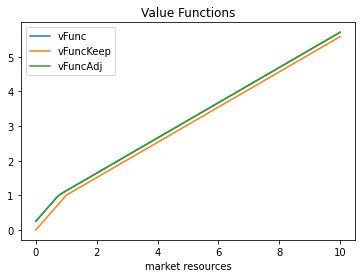

In [20]:
print('Value function for an idiosyncratic shocks consumer type with durable stock =', 
      n, ', alpha', DurableExampleadjC.alpha, ', and Adjustment Costs', DurableExampleadjC.adjC)

plt.plot(grid, Results['vFunc_test'], label = "vFunc")
plt.plot(grid, Results['vFuncKeep_test'], label = "vFuncKeep")
plt.plot(grid, Results['vFuncAdj_test'], label = "vFuncAdj")
plt.title('Value Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

Adjusting function for an idiosyncratic shocks consumer type with durable stock = 0.25 , alpha 1.0 , and Adjustment Costs 0.0


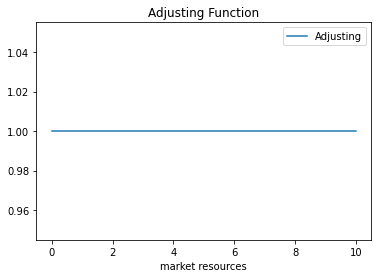

In [21]:
print('Adjusting function for an idiosyncratic shocks consumer type with durable stock =', 
      n, ', alpha', DurableExampleadjC.alpha, ', and Adjustment Costs', DurableExampleadjC.adjC)

plt.plot(grid, Results['adjusting'], label = "Adjusting")
plt.title('Adjusting Function')
plt.xlabel('market resources')
plt.legend()
plt.show()

### Case 2: alpha<1
With `alpha < 1`, the consumer wants to split total consumption into non-durable and durable consumption. As depreciation rate is still 1, we have two non-durable goods. 

In the special case of `alpha = 0.5` and initial durable stock = 0, durable and non-durable consumption is exactly the same! The total consumption function remains the same as the consumption function of the IndShockConsumerType. Note that the keeper cannot purchase durables and hence tries to overconsume non-durables, but has a strictly lower value function.

In [41]:
### Solve
DurableExampleAlpha = deepcopy(DurableExampleadjC)
DurableExampleAlpha.alpha = 0.5
DurableExampleAlpha.update_income_process()
DurableExampleAlpha.solve()#(verbose=False)

Consumption function for an idiosyncratic shocks consumer type with durable stock = 0 alpha 0.5 , and Adjustment Costs 0.0


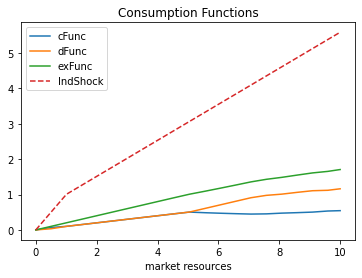

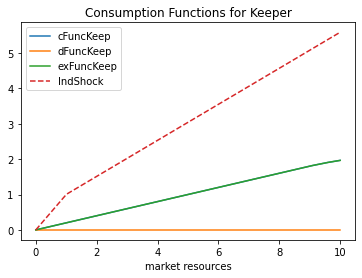

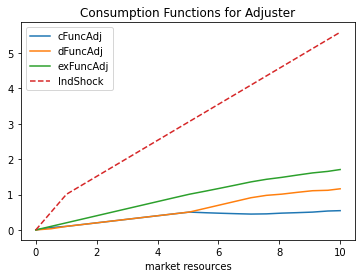

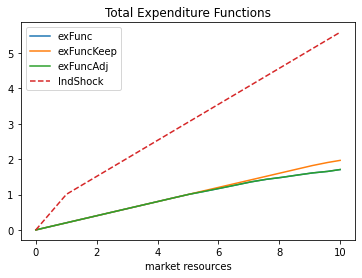

In [44]:
n = 0
print('Consumption function for an idiosyncratic shocks consumer type with durable stock =', n, 'alpha', DurableExampleAlpha.alpha, ', and Adjustment Costs', DurableExampleAlpha.adjC)
Results = Graphfunctions(DurableExampleAlpha,grid,n)

plt.plot(grid, Results['cFunc_test'], label = "cFunc")
plt.plot(grid, Results['dFunc_test'], label = "dFunc")
plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFuncKeep_test'], label = "cFuncKeep")
plt.plot(grid, Results['dFuncKeep_test'], label = "dFuncKeep")
plt.plot(grid, Results['exFuncKeep_test'], label = "exFuncKeep")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions for Keeper')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFuncAdj_test'], label = "cFuncAdj")
plt.plot(grid, Results['dFuncAdj_test'], label = "dFuncAdj")
plt.plot(grid, Results['exFuncAdj_test'], label = "exFuncAdj")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions for Adjuster')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid, Results['exFuncKeep_test'], label = "exFuncKeep")
plt.plot(grid, Results['exFuncAdj_test'], label = "exFuncAdj")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Total Expenditure Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()


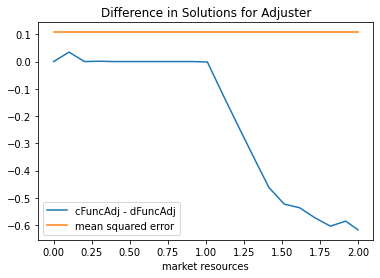

In [46]:
mean = np.ones(100)*np.mean((Results['cFuncAdj_test'] - Results['dFuncAdj_test'])**2)

plt.plot(grid, Results['cFuncAdj_test'] - Results['dFuncAdj_test'], label = "cFuncAdj - dFuncAdj")
plt.plot(grid, mean, label = "mean squared error")
plt.title('Difference in Solutions for Adjuster')
plt.xlabel('market resources')
plt.legend()
plt.show()

Value function for an idiosyncratic shocks consumer type with durable stock = 0 alpha 0.5 , and Adjustment Costs 0.0


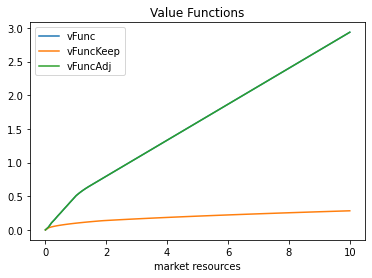

In [25]:
print('Value function for an idiosyncratic shocks consumer type with durable stock =', n, 'alpha', DurableExampleAlpha.alpha, ', and Adjustment Costs', DurableExampleAlpha.adjC)

plt.plot(grid, Results['vFunc_test'], label = "vFunc")
plt.plot(grid, Results['vFuncKeep_test'], label = "vFuncKeep")
plt.plot(grid, Results['vFuncAdj_test'], label = "vFuncAdj")
plt.title('Value Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

Adjusting function for an idiosyncratic shocks consumer type with durable stock = 0 and alpha 0.5


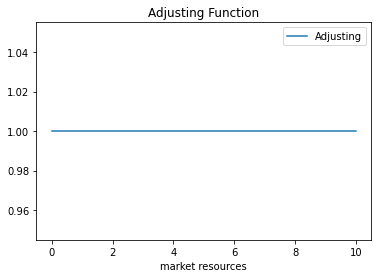

In [26]:
print('Adjusting function for an idiosyncratic shocks consumer type with durable stock =', n, 'and alpha', DurableExampleAlpha.alpha)

plt.plot(grid, Results['adjusting'], label = "Adjusting")
plt.title('Adjusting Function')
plt.xlabel('market resources')
plt.legend()
plt.show()

### BUG:
- For the adjuster, cFuncAdj != dFuncAdj!!
- Tried different optimizers: Still a bug
- vFuncKeep might be the problem

### Case 3: Depreciation rate < 1
With `alpha = 1` and a depreciation rate below `cDepr < 1`, part of the durable good can be consumed in the following period. Now, durable consumption increases.

In [27]:
DurableExampledDepr = deepcopy(DurableExampleAlpha)
DurableExampledDepr.dDepr = 0.8
DurableExampledDepr.update_income_process()
DurableExampledDepr.solve()#(verbose=False)

Consumption function for an idiosyncratic shocks consumer type with durable stock = 0 , alpha 0.5 , and Depreciation rate 0.8


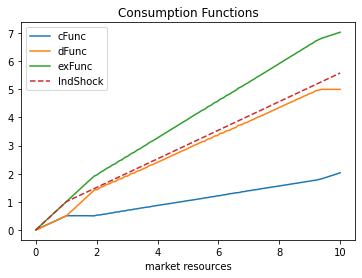

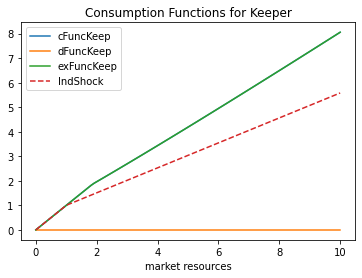

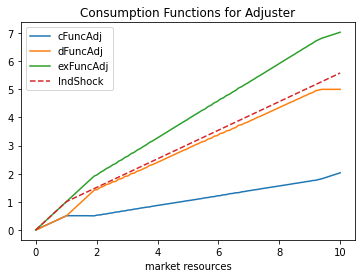

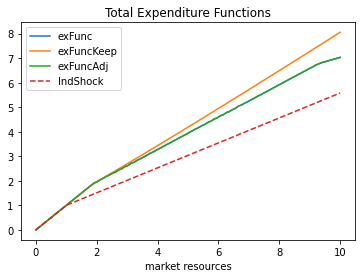

In [28]:
n = 0
print('Consumption function for an idiosyncratic shocks consumer type with durable stock =', n, ', alpha', DurableExampledDepr.alpha, ', and Depreciation rate', 
      DurableExampledDepr.dDepr)

Results = Graphfunctions(DurableExampledDepr,grid,n)

plt.plot(grid, Results['cFunc_test'], label = "cFunc")
plt.plot(grid, Results['dFunc_test'], label = "dFunc")
plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFuncKeep_test'], label = "cFuncKeep")
plt.plot(grid, Results['dFuncKeep_test'], label = "dFuncKeep")
plt.plot(grid, Results['exFuncKeep_test'], label = "exFuncKeep")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions for Keeper')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFuncAdj_test'], label = "cFuncAdj")
plt.plot(grid, Results['dFuncAdj_test'], label = "dFuncAdj")
plt.plot(grid, Results['exFuncAdj_test'], label = "exFuncAdj")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions for Adjuster')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid, Results['exFuncKeep_test'], label = "exFuncKeep")
plt.plot(grid, Results['exFuncAdj_test'], label = "exFuncAdj")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Total Expenditure Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()


Value function for an idiosyncratic shocks consumer type with durable stock = 0 , alpha 0.5 , and Depreciation rate 0.8


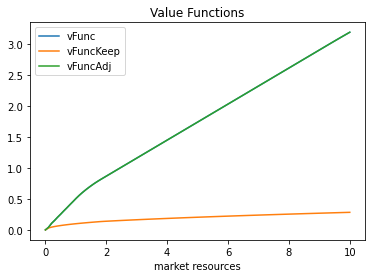

In [29]:
print('Value function for an idiosyncratic shocks consumer type with durable stock =', n, ', alpha', DurableExampledDepr.alpha, ', and Depreciation rate', 
      DurableExampledDepr.dDepr)

plt.plot(grid, Results['vFunc_test'], label = "vFunc")
plt.plot(grid, Results['vFuncKeep_test'], label = "vFuncKeep")
plt.plot(grid, Results['vFuncAdj_test'], label = "vFuncAdj")
plt.title('Value Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

Adjusting function for an idiosyncratic shocks consumer type with durable stock = 0.5 and 0.8


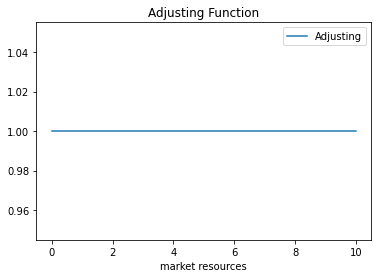

In [30]:
print('Adjusting function for an idiosyncratic shocks consumer type with durable stock =', DurableExampleAlpha.alpha, 'and', DurableExampledDepr.dDepr)

plt.plot(grid, Results['adjusting'], label = "Adjusting")
plt.title('Adjusting Function')
plt.xlabel('market resources')
plt.legend()
plt.show()

### BUG:
- cFuncAdj and dFuncAdj are not smooth!

### Case 4: Use calibration from the original code

In [31]:
DurableReplication = DurableConsumerType(**init_durable)
DurableReplication.alpha = 0.9
DurableReplication.DiscFac = 0.965
DurableExample.adjC = 0.10
DurableReplication.dDepr = 0.15
DurableReplication.PermShkStd = [0.1]
DurableReplication.TranShkStd = [0.1]
DurableReplication.T_Sim = 5

DurableReplication.update_income_process()
DurableReplication.solve()#(verbose=False)

Consumption function for an idiosyncratic shocks consumer type with durable stock = 0 , alpha 0.9 , depreciation rate 0.15 , and adjustment costs 0.1


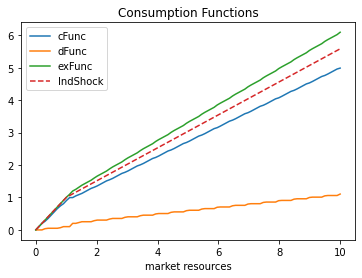

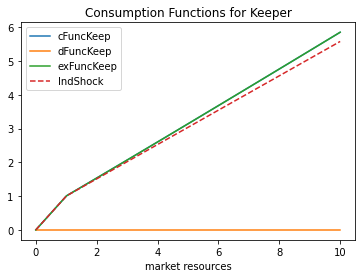

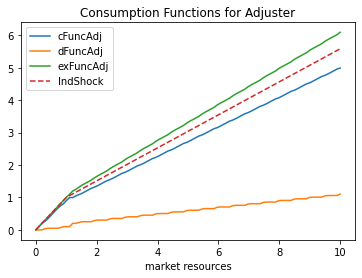

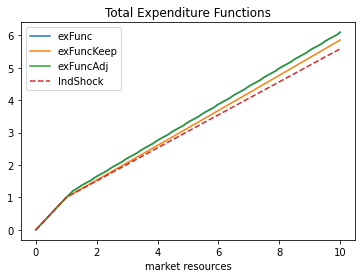

In [32]:
n = 0
print('Consumption function for an idiosyncratic shocks consumer type with durable stock =', n, ', alpha', DurableReplication.alpha, ', depreciation rate', 
      DurableReplication.dDepr, ', and adjustment costs', DurableExample.adjC)

Results = Graphfunctions(DurableReplication,grid,n)

plt.plot(grid, Results['cFunc_test'], label = "cFunc")
plt.plot(grid, Results['dFunc_test'], label = "dFunc")
plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFuncKeep_test'], label = "cFuncKeep")
plt.plot(grid, Results['dFuncKeep_test'], label = "dFuncKeep")
plt.plot(grid, Results['exFuncKeep_test'], label = "exFuncKeep")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions for Keeper')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFuncAdj_test'], label = "cFuncAdj")
plt.plot(grid, Results['dFuncAdj_test'], label = "dFuncAdj")
plt.plot(grid, Results['exFuncAdj_test'], label = "exFuncAdj")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Consumption Functions for Adjuster')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid, Results['exFuncKeep_test'], label = "exFuncKeep")
plt.plot(grid, Results['exFuncAdj_test'], label = "exFuncAdj")
plt.plot(grid,cFunc_IndShock, '--', label = "IndShock")
plt.title('Total Expenditure Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()


Value function for an idiosyncratic shocks consumer type with durable stock = 0 , alpha 0.9 , depreciation rate 0.15 , and adjustment costs 0.1


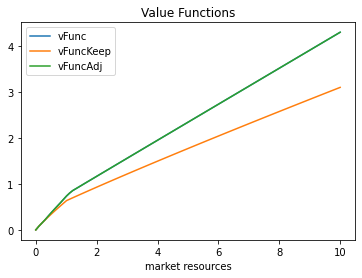

In [33]:
print('Value function for an idiosyncratic shocks consumer type with durable stock =', n, ', alpha', DurableReplication.alpha, ', depreciation rate', 
      DurableReplication.dDepr, ', and adjustment costs', DurableExample.adjC)

plt.plot(grid, Results['vFunc_test'], label = "vFunc")
plt.plot(grid, Results['vFuncKeep_test'], label = "vFuncKeep")
plt.plot(grid, Results['vFuncAdj_test'], label = "vFuncAdj")
plt.title('Value Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

Adjusting function for an idiosyncratic shocks consumer type with durable stock = 0 , alpha 0.9 , depreciation rate 0.15 , and adjustment costs 0.1


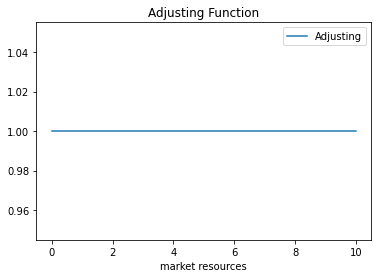

In [34]:
print('Adjusting function for an idiosyncratic shocks consumer type with durable stock =', n, ', alpha', DurableReplication.alpha, ', depreciation rate', 
      DurableReplication.dDepr, ', and adjustment costs', DurableExample.adjC)

plt.plot(grid, Results['adjusting'], label = "Adjusting")
plt.title('Adjusting Function')
plt.xlabel('market resources')
plt.legend()
plt.show()

# SIMULATION

### Let's start with the basic with alpha = 1
For comparison: https://github.com/econ-ark/HARK/blob/master/examples/ConsIndShockModel/IndShockConsumerType.ipynb

We now can track the stock of durables (nNrm), durable consumption (dNrm), total expenditure (exNrm), and whether the agent adjusts or not (adjusting).

In [35]:
DurableExamplecSim = DurableConsumerType(**init_durable)
DurableExamplecSim.alpha = 1.0
DurableExamplecSim.cAdj = 1.0
DurableExamplecSim.cDepr = 1.0
DurableExamplecSim.T_sim = 5
DurableExamplecSim.AgentCount = 5
DurableExamplecSim.update_income_process()
DurableExamplecSim.solve()#(verbose=False)

DurableExamplecSim.track_vars = ['aNrm','mNrm','cNrm','pLvl','nNrm', 'dNrm', 'exNrm', 'adjusting']
DurableExamplecSim.initialize_sim()
DurableExamplecSim.simulate()

{'aNrm': array([[3.6687344 , 0.43274908, 0.68683658, 0.53074475, 0.88723519],
        [1.85329694, 0.21590695, 0.34432978, 0.26542431, 0.4456908 ],
        [0.93481017, 0.1063697 , 0.17124922, 0.13139108, 0.22244559],
        [0.46976607, 0.05088661, 0.08375745, 0.06356355, 0.10967371],
        [0.23460932, 0.02277642, 0.03943024, 0.02919912, 0.05256057]]),
 'mNrm': array([[8.4747388 , 1.88749906, 2.40451551, 2.08696213, 2.81201426],
        [4.77879644, 1.44573156, 1.70744168, 1.54666709, 1.91385224],
        [2.90889585, 1.22238415, 1.35465967, 1.27338704, 1.45906152],
        [1.96285448, 1.10956079, 1.17638669, 1.13533282, 1.22911896],
        [1.48385906, 1.05241321, 1.08627017, 1.06547046, 1.11296392]]),
 'cNrm': array([[4.80600439, 1.45474998, 1.71767893, 1.55621739, 1.92477907],
        [2.92549949, 1.22982461, 1.3631119 , 1.28124278, 1.46816144],
        [1.97408568, 1.11601446, 1.18341046, 1.14199595, 1.23661594],
        [1.4930884 , 1.05867418, 1.09262924, 1.07176926, 1.119

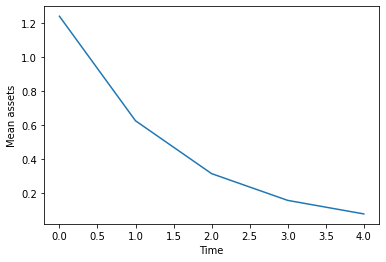

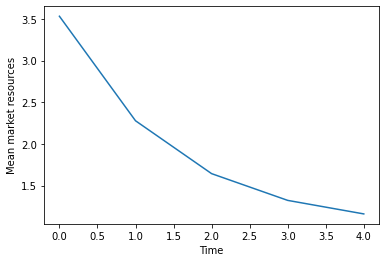

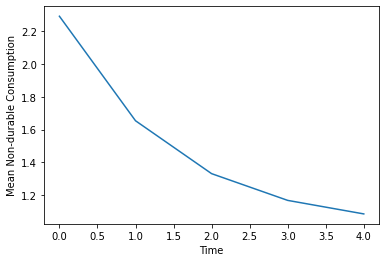

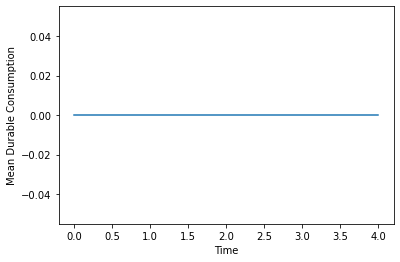

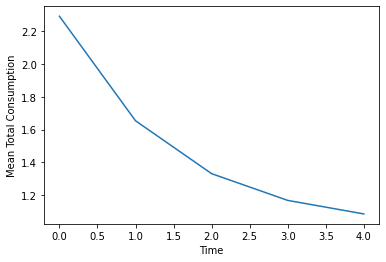

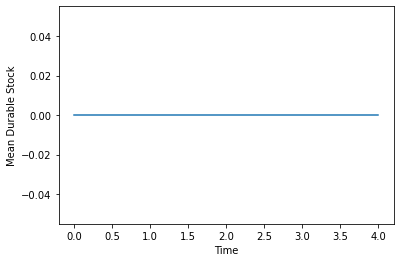

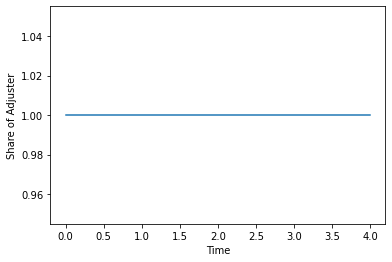

In [36]:
### plot
plt.plot(np.mean(DurableExamplecSim.history['aNrm'],axis=1))
plt.xlabel('Time')
plt.ylabel('Mean assets')
plt.show()

plt.plot(np.mean(DurableExamplecSim.history['mNrm'],axis=1))
plt.xlabel('Time')
plt.ylabel('Mean market resources')
plt.show()

plt.plot(np.mean(DurableExamplecSim.history['cNrm'],axis=1))
plt.xlabel('Time')
plt.ylabel('Mean Non-durable Consumption')
plt.show()

plt.plot(np.mean(DurableExamplecSim.history['dNrm'],axis=1))
plt.xlabel('Time')
plt.ylabel('Mean Durable Consumption')
plt.show()

plt.plot(np.mean(DurableExamplecSim.history['exNrm'],axis=1))
plt.xlabel('Time')
plt.ylabel('Mean Total Consumption')
plt.show()

plt.plot(np.mean(DurableExamplecSim.history['nNrm'],axis=1))
plt.xlabel('Time')
plt.ylabel('Mean Durable Stock')
plt.show()

plt.plot(np.mean(DurableExamplecSim.history['adjusting'],axis=1))
plt.xlabel('Time')
plt.ylabel('Share of Adjuster')
plt.show()


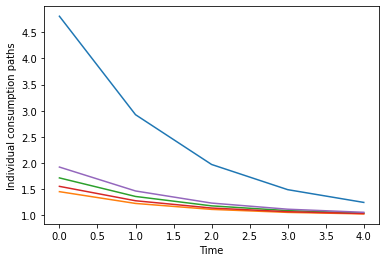

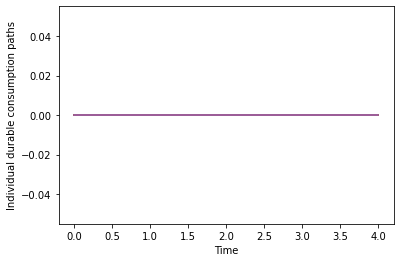

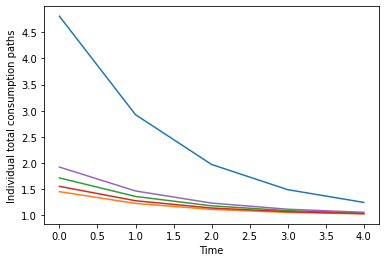

In [37]:
# Plot for the first 5 agents
plt.plot(DurableExamplecSim.history['cNrm'][:,0:5])
plt.xlabel('Time')
plt.ylabel('Individual consumption paths')
plt.show()

plt.plot(DurableExamplecSim.history['dNrm'][:,0:5])
plt.xlabel('Time')
plt.ylabel('Individual durable consumption paths')
plt.show()

plt.plot(DurableExamplecSim.history['exNrm'][:,0:5])
plt.xlabel('Time')
plt.ylabel('Individual total consumption paths')
plt.show()

### When we use the last example with everything

In [38]:
DurableExamplecSim = DurableConsumerType(**init_durable)
#DurableExamplecSim.DiscFac = 1/DurableExamplecSim.Rfree
DurableExamplecSim.alpha = 0.9
DurableExamplecSim.cAdj = 0.15 #0.15
DurableExamplecSim.cDepr = 0.99
DurableExamplecSim.T_sim = 5
DurableExamplecSim.AgentCount = 5
DurableExamplecSim.update_income_process()
DurableExamplecSim.solve()#(verbose=False)

DurableExamplecSim.track_vars = ['aNrm','mNrm','cNrm','pLvl','nNrm', 'dNrm', 'exNrm', 'adjusting']
DurableExamplecSim.initialize_sim()
DurableExamplecSim.simulate()

{'aNrm': array([[4.3039253 , 0.61672482, 0.91320607, 0.72641225, 1.14392207],
        [2.59850875, 0.48802343, 0.64378944, 0.54569489, 0.7886631 ],
        [1.6274016 , 0.41630684, 0.50225873, 0.45066349, 0.57839316],
        [1.05189679, 0.35478844, 0.42781717, 0.38425953, 0.46786195],
        [0.72420081, 0.31784704, 0.36466199, 0.33326281, 0.39901235]]),
 'mNrm': array([[8.4747388 , 1.88749906, 2.40451551, 2.08696213, 2.81201426],
        [5.43304306, 1.63522656, 1.94060225, 1.74820462, 2.17823973],
        [3.67646402, 1.50266413, 1.66310312, 1.56206574, 1.81232299],
        [2.67622365, 1.42879604, 1.51732649, 1.46418339, 1.59574496],
        [2.0834537 , 1.36543209, 1.44065169, 1.39578732, 1.48189781]]),
 'cNrm': array([[4.1708135 , 1.27077424, 1.49130944, 1.36054988, 1.66809219],
        [2.8345343 , 1.14720313, 1.29681282, 1.20250973, 1.38957663],
        [2.04906242, 1.0863573 , 1.16084439, 1.11140225, 1.23392983],
        [1.62432685, 1.0740076 , 1.08950932, 1.07992386, 1.127

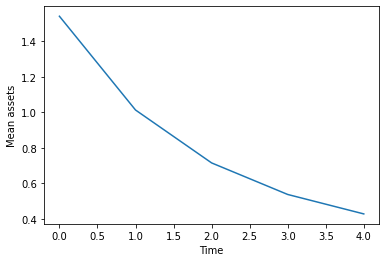

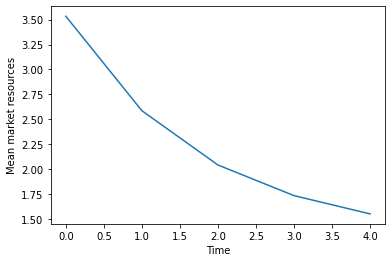

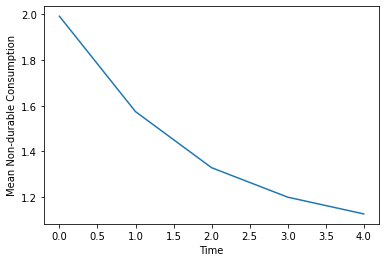

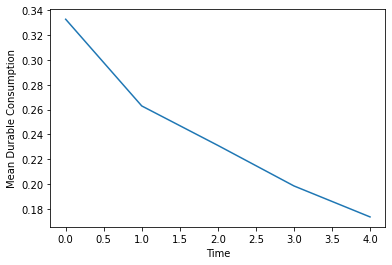

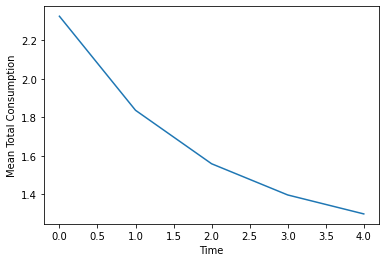

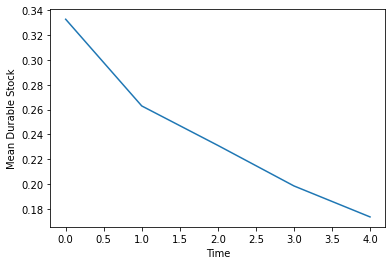

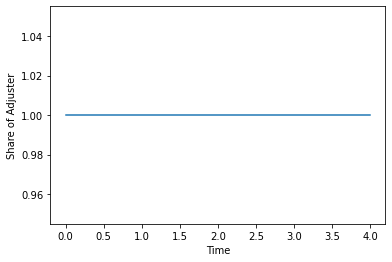

In [39]:
### plot
plt.plot(np.mean(DurableExamplecSim.history['aNrm'],axis=1))
plt.xlabel('Time')
plt.ylabel('Mean assets')
plt.show()

plt.plot(np.mean(DurableExamplecSim.history['mNrm'],axis=1))
plt.xlabel('Time')
plt.ylabel('Mean market resources')
plt.show()

plt.plot(np.mean(DurableExamplecSim.history['cNrm'],axis=1))
plt.xlabel('Time')
plt.ylabel('Mean Non-durable Consumption')
plt.show()

plt.plot(np.mean(DurableExamplecSim.history['dNrm'],axis=1))
plt.xlabel('Time')
plt.ylabel('Mean Durable Consumption')
plt.show()

plt.plot(np.mean(DurableExamplecSim.history['exNrm'],axis=1))
plt.xlabel('Time')
plt.ylabel('Mean Total Consumption')
plt.show()

plt.plot(np.mean(DurableExamplecSim.history['nNrm'],axis=1))
plt.xlabel('Time')
plt.ylabel('Mean Durable Stock')
plt.show()

plt.plot(np.mean(DurableExamplecSim.history['adjusting'],axis=1))
plt.xlabel('Time')
plt.ylabel('Share of Adjuster')
plt.show()

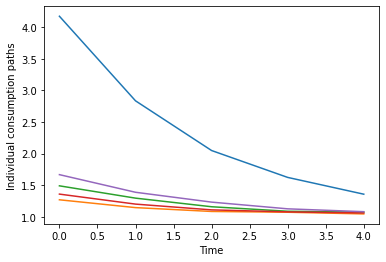

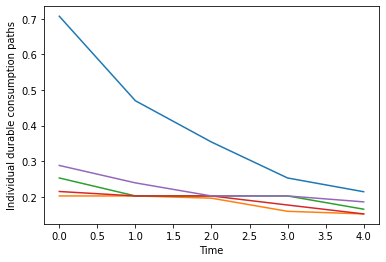

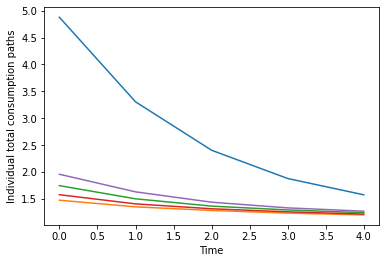

In [40]:
# Plot for the first 5 agents
plt.plot(DurableExamplecSim.history['cNrm'][:,0:5])
plt.xlabel('Time')
plt.ylabel('Individual consumption paths')
plt.show()

plt.plot(DurableExamplecSim.history['dNrm'][:,0:5])
plt.xlabel('Time')
plt.ylabel('Individual durable consumption paths')
plt.show()

plt.plot(DurableExamplecSim.history['exNrm'][:,0:5])
plt.xlabel('Time')
plt.ylabel('Individual total consumption paths')
plt.show()

### Bug:
- durable consumption function is not always convex.

# TO-DO LIST:

1. Fix Bugs
- cFuncAdj != dFuncAdj for alpha = 0.5, adjustment cost = 0, depreciation = 1 --> use a different optimization method? (For Jeppe it is also not the same)
- vFuncAdj != vFuncKeep for alpha = 1. Error e^-16

2. Simulation
- fix bugs: fixed when solution method is fixed?
- lifecycle: unpack

3. Replace functioncs from Jeppe with HARK tools.
- Utility functions
- Upper Envelope theorem (DCEGM)
- optimizer

4. Simulate change in income risk: from good state to bad state: do I get a business cycle in durables?

5. General Equilibrium Model